In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container{ width:95%}</style>"))
import sys
print(sys.executable) 
#import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import seaborn as sns
from sklearn import preprocessing

from IPython.display import HTML
HTML('''<script>
code_show=false; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
El codigo Python de este cuaderno está oculto para facilitar la lectura.
Para mostrar/ocultar el código, haz click <a href="javascript:code_toggle()">aquí.</a>.''')

## Load metrics

In [ ]:
import pandas as pd
df_alg=pd.read_csv('../output/metrics2309/merged_output_umda.txt')
convert_dict = {'Dataset': "string", 
                'Algorithm': "string",
                'Population Length': "int64",
                'Generations': "int64",
                'Time(s)': "float64",
                'AvgValue': "float64",
                'BestAvgValue': "float64",
                'BestGeneration': "int64",
                'HV': "float64",
                'Spread': "float64",
                'NumSolutions': "float64",
                'Spacing': "float64",
                'NumGenerations': "int64"
               } 
#df_alg = df_alg.astype(convert_dict) 

df_alg2=pd.read_csv('../output/metrics2309/merged_output_pbil.txt',header=0)

convert_dict = {'Dataset': "string", 
                'Algorithm': "string",
                'Population Length': "int64",
                'Generations': "int64",
                'Time(s)': "float64",
                'AvgValue': "float64",
                'BestAvgValue': "float64",
                'HV': "float64",
                'Spread': "float64",
                'NumSolutions': "int64",
                'Spacing': "float64",
                'NumGenerations': "int64"
               } 
#df_alg2 = df_alg2.astype(convert_dict)
#display(df_alg2.head(200))

df_alg3=pd.read_csv('../output/metrics2309/merged_output_grasp.txt')
#df_alg3.astype({'Evaluations': 'int64'}).dtypes
df_alg = df_alg.append(df_alg2)
df_alg = df_alg.append(df_alg3)
display(df_alg.head(200))

In [ ]:
configs=["Algorithm","Dataset"]

df_a=(
    df_alg[df_alg["Evaluations"]==10000].groupby(configs)\
    [['Time(s)', 'HV', 'Spread',"AvgValue","NumSolutions","Spacing","Requirements per sol","NumEvaluations"]]\
    .agg(mean_time=('Time(s)', 'mean'),
         mean_hv=('HV', 'mean'),
         mean_spread=('Spread', 'mean'),
         mean_avgvalue=('AvgValue', 'mean'),
         mean_numsolutions=('NumSolutions', 'mean'),
         mean_spacing=('Spacing', 'mean'),
         mean_reqs_per_sol=('Requirements per sol', 'mean'),
         mean_numevaluations=('NumEvaluations', 'mean'),
        )
)
display(df_a)

In [ ]:
df_a=(
    df_alg3[df_alg3["Evaluations"]==0].groupby(configs)\
    [['Time(s)', 'HV', 'Spread',"AvgValue","NumSolutions","Spacing","Requirements per sol","NumEvaluations"]]\
    .agg(mean_time=('Time(s)', 'mean'),
         mean_hv=('HV', 'mean'),
         mean_spread=('Spread', 'mean'),
         mean_avgvalue=('AvgValue', 'mean'),
         mean_numsolutions=('NumSolutions', 'mean'),
         mean_spacing=('Spacing', 'mean'),
         mean_reqs_per_sol=('Requirements per sol', 'mean'),
         mean_numevaluations=('NumEvaluations', 'mean'),
        )
)
display(df_a)

## Pareto analysis
Change ```dataset``` value to load different dataset Paretos

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from algorithms.GRASP.GRASP import GRASP
from algorithms.genetic.nsgaii.nsgaii_algorithm import NSGAIIAlgorithm
from algorithms.genetic.geneticnds.geneticnds_algorithm import GeneticNDSAlgorithm
from algorithms.EDA.UMDA.umda_algorithm import UMDAAlgorithm
from algorithms.EDA.PBIL.pbil_algorithm import PBILAlgorithm 
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower

sizes=[30,25,20,15,10,7,5]
markers=["+","x","s","v","h","o"]
labels=["Random","GPPR-MO-PR"]
datasets=["1","2","s1","s2","s3"]
dataset="s2"
seed=10
generations=100
solutions_per_iteration=100
population_length=100
gens_genetic=100
algorithms = [
    GRASP(dataset=dataset,iterations=generations,solutions_per_iteration=solutions_per_iteration,seed=seed,
           init_type="uniform",local_search_type="None",path_relinking_mode="None"),
    GRASP(dataset=dataset,iterations=generations,solutions_per_iteration=solutions_per_iteration,seed=seed,
           init_type="stochastically",local_search_type="best_first_neighbor_random_domination",
          path_relinking_mode="after_local"),
    #UMDAAlgorithm(dataset_name=dataset,population_length=population_length,max_generations=generations,
    #             max_evaluations=0,selected_individuals=50)
]

for i in range(len(algorithms)):   
    if "GRASP" in algorithms[i].file:
        file = "../output/output/pareto-grasp-"+algorithms[i].file
    else:
        file = "../output/output/pareto-genetic-"+algorithms[i].file
    data = np.loadtxt(file,delimiter=',', dtype=float)
    x,y=data.T
    plt.scatter(x,y,label=labels[i],s=50,marker=markers[i])

algorithm=UMDAAlgorithm(dataset_name=dataset,population_length=100,max_generations=100,
             max_evaluations=0,selected_individuals=50,selection_scheme="nds",replacement_scheme="replacement")
result=algorithm.run()
func = [i.objectives for i in result["population"]]
function1 = [i[0].value for i in func]
function2 = [i[1].value for i in func]
plt.scatter(function2, function1, marker='o',label=algorithm.get_name())

#algorithm=PBILAlgorithm(dataset_name=dataset,population_length=100,max_generations=100,
#             max_evaluations=0,learning_rate=0.2,mutation_prob=0.2,mutation_shift=0.2)
#result=algorithm.run()
#func = [i.objectives for i in result["population"]]
#function3 = [i[0].value for i in func]
#function4 = [i[1].value for i in func]
#plt.scatter(function4, function3, marker='s',label="PBIL")





#file = "output/backtracking.txt"
#data = np.loadtxt(file,delimiter=',', dtype=float)
#x,y=data.T
#plt.scatter(x,y,label="optimo",s=10)
plt.title(dataset)
plt.xlabel('Effort', fontsize=12)
plt.ylabel('Satisfaction', fontsize=12)
plt.legend(loc="lower right")
plt.title("Dataset "+dataset)
plt.grid(True)
#plt.show()

In [ ]:
import os
import imageio

gif_name = "prueba"

filenames=[]
paretos = result["paretos"]
#print(len(paretos))
for pareto_index in range(len(paretos)):
    plt.cla()
    plt.clf()
    #print(paretos[pareto_index],pareto_index)
    for i in range(len(algorithms)):   
        if "GRASP" in algorithms[i].file:
            file = "../output/output/pareto-grasp-"+algorithms[i].file
        else:
            file = "../output/output/pareto-genetic-"+algorithms[i].file
        data = np.loadtxt(file,delimiter=',', dtype=float)
        x,y=data.T
        plt.scatter(x,y,label=labels[i],s=50,marker=markers[i])

    plt.scatter(function2, function1, marker='o',label="UMDA")
    #for j in paretos[pareto_index]:
        #print(j.objectives)
    func = [j.objectives for j in paretos[pareto_index]]
    function3 = [j[0].value for j in func]
    function4 = [j[1].value for j in func]
    plt.scatter(function4, function3, marker='s',label="PBIL")
    plt.title(dataset)
    plt.xlabel('Effort', fontsize=12)
    plt.ylabel('Satisfaction', fontsize=12)
    plt.legend(loc="lower right")
    plt.title("Dataset "+dataset)
    plt.grid(True)
    plt.draw()
    #fig = plt.figure()
    #plt.show()
    #plt.plot(range(10))
    filename = f'temp/temp'+str(pareto_index+1)+'.png'
    filenames.append(filename)
    plt.savefig(filename, dpi=100)
    
    
    
# Build GIF
print('Creating gif\n')
with imageio.get_writer(f'{gif_name}.gif', mode='I',fps=4) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    for i in range(5):
        writer.append_data(image)
        
print('Gif saved\n')
print('Removing Images\n')
# Remove files
for filename in set(filenames):
    os.remove(filename)
print('DONE')

In [ ]:
import os
import imageio

import matplotlib.pyplot as plt
import numpy as np

def createGIF(algorithms,input_folder="temp", output_filename="example_gif", dpi=100,fps=1,pareto_files=None):
    plt.rcParams['figure.figsize'] = [16, 10]
    plt.rcParams['figure.dpi'] = 200
    alg_results=[]
    filenames=[]
    # execute each algorithm and store pareto steps
    for alg_index in range(len(algorithms)): 
        if pareto_files is not None and pareto_files[alg_index]:
            if "GRASP" in algorithms[alg_index].file:
                file = "../output/output/pareto-grasp-"+algorithms[alg_index].file
            else:
                file = "../output/output/pareto-genetic-"+algorithms[alg_index].file
            data = np.loadtxt(file,delimiter=',', dtype=float)
            x,y=data.T
            plt.scatter(x,y,label=algorithms[alg_index].get_name(),s=50#,marker=markers[i]
                       )
        else:
            result=algorithms[alg_index].run()
            alg_results.append(result["paretos"])
            #func = [i.objectives for i in result["population"]]
            #function1 = [i[0].value for i in func]
            #function2 = [i[1].value for i in func]
            #plt.scatter(function2, function1,label=algorithms[alg_index].get_name())
            
    # loop pareto steps and generate a frame with all points for all algorithms
    for pareto_index in range(len(alg_results[0])):
        plt.cla()
        plt.clf()
        # scatter all algorithm intermediate pareto results for a frame
        for alg_index in range(len(algorithms)): 
            if pareto_files is not None and pareto_files[alg_index]:
                if "GRASP" in algorithms[alg_index].file:
                    file = "../output/output/pareto-grasp-"+algorithms[alg_index].file
                else:
                    file = "../output/output/pareto-genetic-"+algorithms[alg_index].file
                data = np.loadtxt(file,delimiter=',', dtype=float)
                x,y=data.T
                print(f"NDS loaded from file has {len(x)} solution(s)")
                plt.scatter(x,y,label=algorithms[alg_index].get_name(),s=50#,marker=markers[i]
                           )
            else:
                func = [j.objectives for j in alg_results[alg_index][pareto_index]]
                functiony = [j[0].value for j in func]
                functionx = [j[1].value for j in func]
                plt.scatter(functionx, functiony,label=algorithms[alg_index].get_name())
            
        # config frame
        plt.xlabel('Effort', fontsize=12)
        plt.ylabel('Satisfaction', fontsize=12)
        plt.legend(loc="lower right")
        plt.title("Dataset "+str(algorithms[0].dataset_name))
        plt.grid(True)
        plt.draw()
        # store frame
        #filename = f'input_folder+'/temp'+str(pareto_index+1)+'.png'
        filename = f'{input_folder}/temp{str(pareto_index+1)}.png'
        filenames.append(filename)
        plt.savefig(filename, dpi=dpi)
        
    
    # Build GIF
    print('Creating gif\n')
    with imageio.get_writer(f'{output_filename}.gif', mode='I',fps=fps) as writer:
        for filename in filenames:
            image = imageio.imread(filename)
            writer.append_data(image)
        for i in range(fps*5):
            writer.append_data(image)

    print('Gif saved\n')
    print('Removing Images\n')
    # Remove files
    for filename in set(filenames):
        os.remove(filename)
    print('DONE')
    

In [ ]:
from algorithms.GRASP.GRASP import GRASP
from algorithms.genetic.nsgaii.nsgaii_algorithm import NSGAIIAlgorithm
from algorithms.genetic.geneticnds.geneticnds_algorithm import GeneticNDSAlgorithm
from algorithms.EDA.UMDA.umda_algorithm import UMDAAlgorithm
from algorithms.EDA.PBIL.pbil_algorithm import PBILAlgorithm 

dataset = "s2"
generations=100
solutions_per_iteration=100
population_length=100
gens_genetic=100
seed = 10
algorithms = [
    PBILAlgorithm(dataset_name=dataset,population_length=population_length,max_generations=generations,
             max_evaluations=0,learning_rate=0.2,mutation_prob=0.2,mutation_shift=0.2,debug_mode=True),
    GRASP(dataset=dataset,iterations=generations,solutions_per_iteration=solutions_per_iteration,seed=seed,
           init_type="stochastically",local_search_type="best_first_neighbor_random_domination",
          path_relinking_mode="after_local",debug_mode=True),
    GRASP(dataset=dataset,iterations=generations,solutions_per_iteration=solutions_per_iteration,seed=seed,
           init_type="uniform",local_search_type="None",path_relinking_mode="None",debug_mode=True),
    UMDAAlgorithm(dataset_name=dataset,population_length=100,max_generations=100,
             max_evaluations=0,selected_individuals=50)
]

createGIF(algorithms,"temp", "prueba_gif", dpi=100,fps=5,pareto_files=[False,False,False,False])

In [ ]:
im = imageio.get_reader('prueba_gif.gif')
for frame in im:
    print(im.shape) 

## Metrics analysis

In [ ]:
from sklearn import preprocessing
from scipy.stats import ranksums
import numpy as np
import plotly.graph_objects as go
import plotly.offline as pyo
import math
class AlgorithmDataGenetic():
    def __init__(self,a,rs,d,p,g,ss,sc,cs,cp,ms,mp):
        self.a=a
        self.rs=rs
        self.d=d
        self.p=p
        self.g=g
        self.ss=ss
        self.sc=sc
        self.cs=cs
        self.cp=cp
        self.ms=ms
        self.mp=mp
    
    def findConfigurationData(self,df):
        return df[(df["Population Length"]==self.p)&(df["Generations"]==self.g)
                     &(df["Selection Scheme"]==self.ss)&(df["Selection Candidates"]==self.sc)
                     &(df["Crossover Scheme"]==self.cs)&(df["Crossover Probability"]==self.cp)
                     &(df["Mutation Scheme"]==self.ms)&(df["Mutation Probability"]==self.mp)
              &(df["Algorithm"]==self.a)&(df["Replacement Scheme"]==self.rs)
              &(df["Dataset"]==self.d)
             ]
        
class AlgorithmDataGrasp():
    def __init__(self,a,d,it,so,ini,ls,pr):
        self.a=a
        self.it=it
        self.so=so
        self.ls=ls
        self.d=d
        self.ini=ini
        self.pr=pr
        
    def findConfigurationData(self,df):
        return df[(df["Iterations"]==self.it)&(df["Solutions per Iteration"]==self.so)
              &(df["Local Search Type"]==self.ls)&(df["Initialization Type"]==self.ini)
              &(df["Algorithm"]==self.a)&(df["Dataset"]==self.d)&(df["Path Relinking"]==self.pr)
             ]
    
dat="1"

datasets=["1","2","s1","s2","s3"]

cols=["HV","Spread","Spacing","NumSolutions","Time(s)"]
maxmin=[1,-1,1,1,-1]
for dat in datasets:
    print("------Dataset "+dat+"-----")
    algs = [
        AlgorithmDataGenetic("GeneticNDSAlgorithm",'elitism',dat,100,100,"tournament",2,"onepoint",0.8,"flip1bit",1.0),
        AlgorithmDataGenetic("NSGAIIAlgorithm",'elitism',dat,100,100,"tournament",2,"onepoint",0.6,"flip1bit",1.0),
        AlgorithmDataGrasp("GRASP",dat,100,100,"stochastically","best_first_neighbor_random_domination","after_local"),
    ]
    for j in range(len(cols)): 
        print(cols[j])
        results=list()
        best_avg=0
        best_avgn=10**9
        best_alg_index=None
        for i in range(len(algs)):
            avg=np.mean((algs[i].findConfigurationData(df_alg)[cols])[cols[j]].values)
            results.append("{:.3f}".format(avg))
            if maxmin[j]>0 and avg>best_avg:
                best_avg=avg
                best_alg_index=i
            elif maxmin[j]<0 and avg<best_avgn:
                best_avgn=avg
                best_alg_index=i

        p_best=True
        p_list=[]
        for i in range(len(algs)):
            if i!=best_alg_index:
                dataA=(algs[best_alg_index].findConfigurationData(df_alg)[cols])[cols[j]].values
                dataB=(algs[i].findConfigurationData(df_alg)[cols])[cols[j]].values
                _, p = ranksums(dataA, dataB)
                print("p:",p)
                if p>=0.05:
                    #print(dataA)
                    #print(dataB)
                    p_best=False
                else:
                    p_list.append(i)

        if p_best:
            mark = '*'
        else:
            mark = ''
        for index in p_list:
            results[index]=results[index]+'-'
        #results[best_alg_index]=results[best_alg_index]+mark
        results.insert(0,cols[j])
        print(results)


In [ ]:
num_candidates = 30
a = np.random.choice(2,num_candidates)
print("a",a)
costs=np.array([1,2,3,4,5])
#indexes=np.array(a).nonzero()
#print( costs[indexes])
probabilities=np.full(num_candidates,1/num_candidates)
sampled = np.random.choice(np.arange(num_candidates), size=np.random.randint(num_candidates),
                                    replace=False, p=probabilities)
print("sampled",sampled)
b = np.zeros(num_candidates)
b[sampled] = 1
print("b",b)

a = np.random.choice(2,num_candidates)
print("a",a)
print("a",a.nonzero())

In [ ]:
import numpy as np
costs=[1,2,3,4,5]
print(np.sum(costs))

## Bivariate MIMIC

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from algorithms.GRASP.GRASP import GRASP
from algorithms.genetic.nsgaii.nsgaii_algorithm import NSGAIIAlgorithm
from algorithms.genetic.geneticnds.geneticnds_algorithm import GeneticNDSAlgorithm
from algorithms.EDA.UMDA.umda_algorithm import UMDAAlgorithm
from algorithms.EDA.bivariate.MIMIC.mimic_algorithm import MIMICAlgorithm
from algorithms.EDA.PBIL.pbil_algorithm import PBILAlgorithm 
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
sizes=[30,25,20,15,10,7,5]
markers=["+","x","s","v","h","o"]
labels=["Random","GPPR-MO-PR"]
datasets=["1","2","s1","s2","s3"]
dataset="2"
seed=10
generations=500
population_length=500
algorithms = [
    GRASP(dataset=dataset,iterations=generations,solutions_per_iteration=population_length,seed=seed,
           init_type="uniform",local_search_type="None",path_relinking_mode="None"),
    GRASP(dataset=dataset,iterations=generations,solutions_per_iteration=population_length,seed=seed,
           init_type="stochastically",local_search_type="best_first_neighbor_random_domination",
          path_relinking_mode="after_local"),
]
for i in range(len(algorithms)):   
    if "GRASP" in algorithms[i].file:
        file = "../output/output/pareto-grasp-"+algorithms[i].file
    else:
        file = "../output/output/pareto-genetic-"+algorithms[i].file
    data = np.loadtxt(file,delimiter=',', dtype=float)
    x,y=data.T
    plt.scatter(x,y,label=labels[i],s=50,marker=markers[i])
algorithm=MIMICAlgorithm(dataset_name=dataset,population_length=population_length,max_generations=generations,
             max_evaluations=0,selection_scheme="nds")
result=algorithm.run()
func = [i.objectives for i in result["population"]]
function1 = [i[0].value for i in func]
function2 = [i[1].value for i in func]
plt.scatter(function2, function1, marker='o',label=algorithm.get_name())
plt.title(dataset)
plt.xlabel('Effort', fontsize=12)
plt.ylabel('Satisfaction', fontsize=12)
plt.legend(loc="lower right")
plt.title("Dataset "+dataset)
plt.grid(True)

## Dependencies


NDS created has 143 solution(s)

NDS created has 217 solution(s)

NDS created has 107 solution(s)


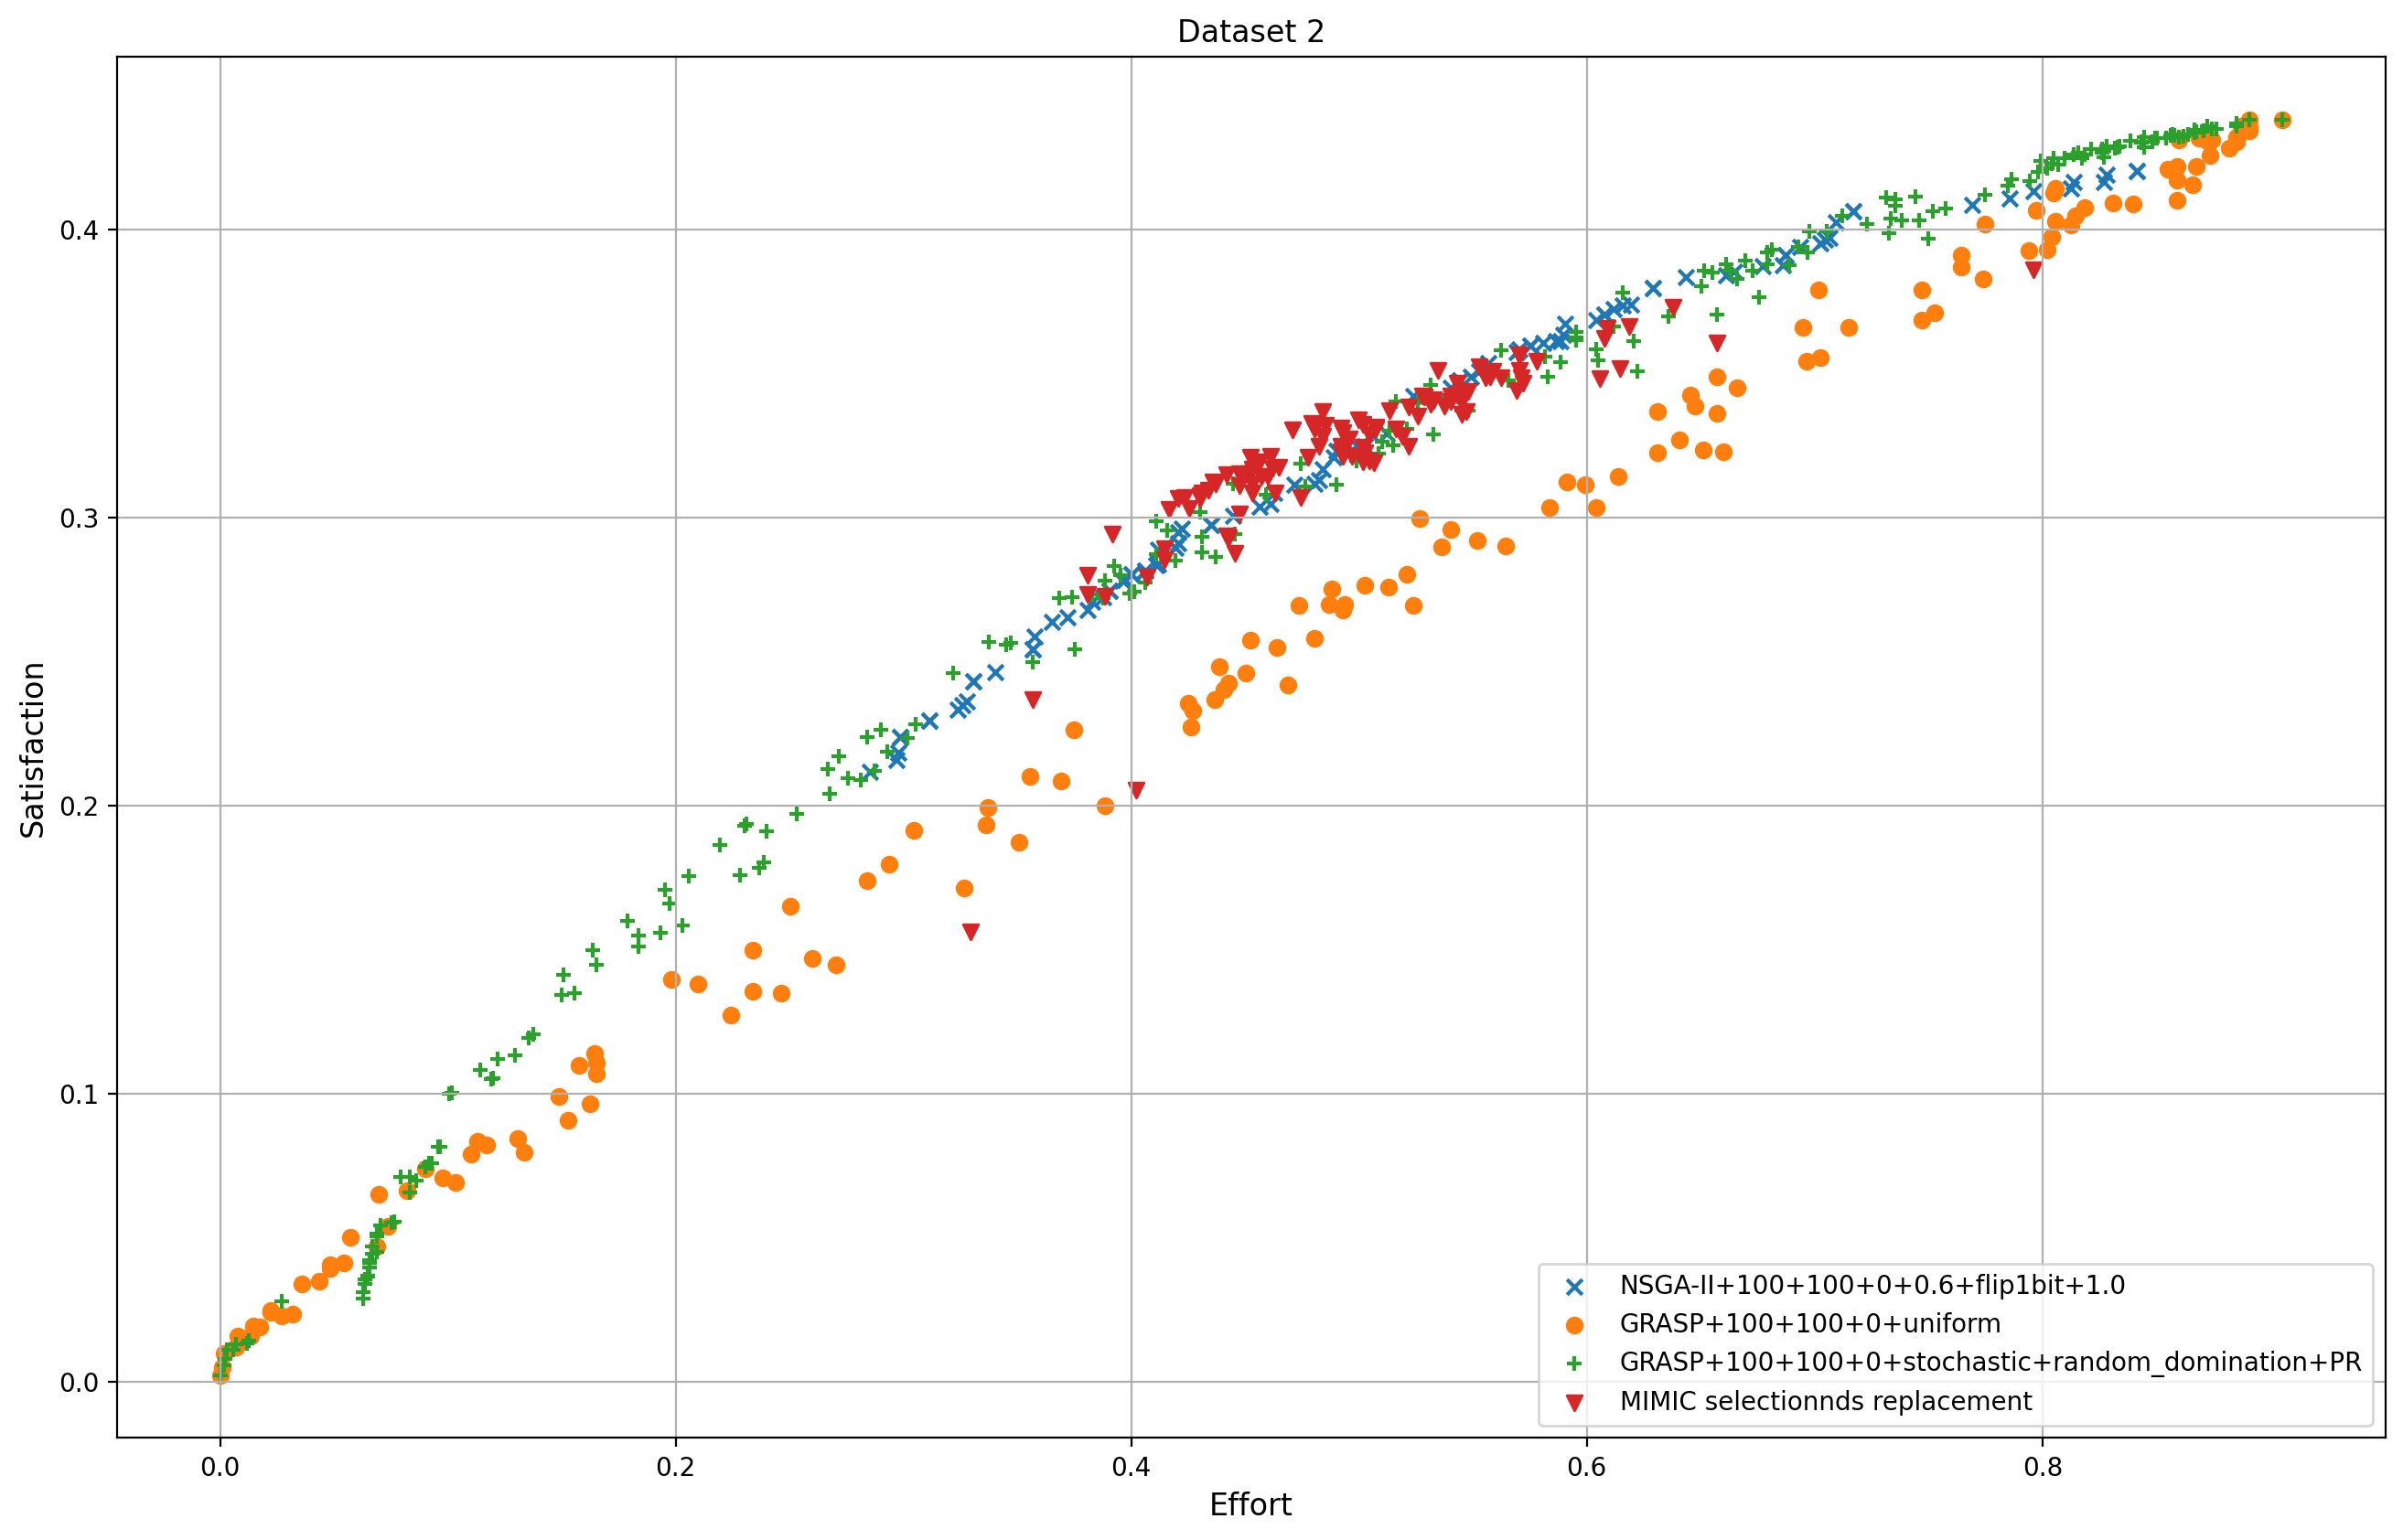

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from algorithms.GRASP.GRASP import GRASP
from algorithms.genetic.nsgaii.nsgaii_algorithm import NSGAIIAlgorithm
from algorithms.genetic.geneticnds.geneticnds_algorithm import GeneticNDSAlgorithm
from algorithms.EDA.UMDA.umda_algorithm import UMDAAlgorithm
from algorithms.EDA.bivariate.MIMIC.mimic_algorithm import MIMICAlgorithm
from algorithms.EDA.PBIL.pbil_algorithm import PBILAlgorithm 
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
sizes=[30,25,20,15,10,7,5]
markers=["+","x","s","v","h","o"]
dataset="2"
seed=10
generations=100
population_length=100
tackle_dependencies=True

algorithm=NSGAIIAlgorithm(dataset_name=dataset,max_generations=generations,population_length=population_length,
                          random_seed=seed,crossover_prob=0.6,crossover="onepoint",mutation_prob=1.0,
                          mutation="flip1bit",replacement="elitism",tackle_dependencies=tackle_dependencies)
result=algorithm.run()
func = [i.objectives for i in result["population"]]
function1 = [i[0].value for i in func]
function2 = [i[1].value for i in func]
plt.scatter(function2, function1, marker='x',label=algorithm.get_name())

algorithm=GRASP(dataset=dataset,iterations=generations,solutions_per_iteration=population_length,seed=seed,
       init_type="uniform",local_search_type="None",path_relinking_mode="None",tackle_dependencies=tackle_dependencies)
result=algorithm.run()
func = [i.objectives for i in result["population"]]
function1 = [i[0].value for i in func]
function2 = [i[1].value for i in func]
plt.scatter(function2, function1, marker='o',label=algorithm.get_name())

algorithm=GRASP(dataset=dataset,iterations=generations,solutions_per_iteration=population_length,seed=seed,
       init_type="stochastically",local_search_type="best_first_neighbor_random_domination",
      path_relinking_mode="after_local",tackle_dependencies=tackle_dependencies)
result=algorithm.run()
func = [i.objectives for i in result["population"]]
function1 = [i[0].value for i in func]
function2 = [i[1].value for i in func]
plt.scatter(function2, function1, marker='+',label=algorithm.get_name())

algorithm=MIMICAlgorithm(dataset_name=dataset,population_length=population_length,max_generations=generations,
             max_evaluations=0,selection_scheme="nds",tackle_dependencies=tackle_dependencies)
result=algorithm.run()
func = [i.objectives for i in result["population"]]
function1 = [i[0].value for i in func]
function2 = [i[1].value for i in func]
plt.scatter(function2, function1, marker='v',label=algorithm.get_name())




plt.title(dataset)
plt.xlabel('Effort', fontsize=12)
plt.ylabel('Satisfaction', fontsize=12)
plt.legend(loc="lower right")
plt.title("Dataset "+dataset)
plt.grid(True)

In [1]:
from algorithms.EDA.UMDA.umda_algorithm import UMDAAlgorithm
from algorithms.EDA.PBIL.pbil_algorithm import PBILAlgorithm 

dataset = "s2"
generations=100
solutions_per_iteration=100
population_length=100
gens_genetic=100
seed = 10
alg=UMDAAlgorithm(dataset_name=dataset,population_length=100,max_generations=100,
             max_evaluations=0,selected_individuals=50)
print(alg.a)

a
